In [174]:
%pip install transformers


This chunk will load the 1.4 version

In [175]:

from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

This chunk will load the fine-tuned model. Located at `PATH = 'sd_models/`

In [1]:
PATH = 'sd_models/'
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
vae = AutoencoderKL.from_pretrained(PATH , subfolder="vae", local_files_only=True)
tokenizer = CLIPTokenizer.from_pretrained(PATH, subfolder="tokenizer",local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(PATH, subfolder="text_encoder",local_files_only=True)
unet = UNet2DConditionModel.from_pretrained(PATH, subfolder="unet",local_files_only=True)
scheduler = UniPCMultistepScheduler.from_pretrained(PATH, subfolder="scheduler",local_files_only=True)


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


# This copy & paste of the `diffusers` page

To speed up inference, move the models to a GPU since, unlike the scheduler, they have trainable weights:

In [2]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features

Create a prompt and a generator seed

In [183]:
prompt = ["a photo of the face of lili fiallo in Times Square New York"]
prompt = ["a photo of lili fiallo with a lego face and wig"]

#prompt = ["una foto de la cara de lili fiallo en Mendoza cuando era joven"]
generator = torch.manual_seed(1311)

Common parameters

In [184]:
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 5.5  # Scale for classifier-free guidance
batch_size = len(prompt)

Tokenize the text and generate the embeddings from the prompt:

In [185]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token. These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:

In [186]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Let’s concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [187]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Create random noise
Next, generate some initial random noise as a starting point for the diffusion process. This is the latent representation of the image, and it’ll be gradually denoised. At this point, the latent image is smaller than the final image size but that’s okay though because the model will transform it into the final 512x512 image dimensions later.

In [188]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

### Denoise the image
Start by scaling the input with the initial noise distribution, sigma, the noise scale value, which is required for improved schedulers like UniPCMultistepScheduler:

In [189]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image described by your prompt. Remember, the denoising loop needs to do three things:

1. Set the scheduler’s timesteps to use during denoising.
2. Iterate over the timesteps.
3. At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [190]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

### Decode the image
The final step is to use the vae to decode the latent representation into an image and get the decoded output with sample:

In [191]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Lastly, convert the image to a PIL.Image to see your generated image!

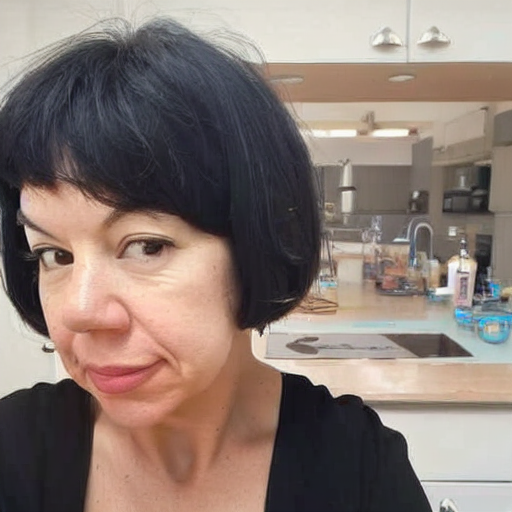

In [192]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]